In [1]:
# Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#After uploading the zip file to your drive mount the drive and unzip it it is always preferable to unzip the file 
#after uploading because it takes relatively lesser time overall and also prevents any data leakage.

# Use the '-d' parameter as the destination for where the files should go
#!unzip "drive/My Drive/ZIP/Bearing_Sensor_Data_pt2.zip" -d "drive/My Drive/Anomaly detection/"

## Analysis of Dataset
We will use vibration sensor readings from the NASA Acoustics and Vibration Database as our dataset for this study. In the NASA study, sensor readings were taken on four bearings that were run to failure under constant load over multiple days. Our dataset consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points per bearing that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

## Anomaly Detection
Anomaly detection is the task of determining when something has gone astray from the “norm”. Anomaly detection using neural networks is modeled in an unsupervised / self-supervised manner; as opposed to supervised learning, where there is a one-to-one correspondence between input feature samples and their corresponding output labels. The presumption is that normal behavior, and hence the quantity of available “normal” data, is the norm and that anomalies are the exception to the norm to the point where the modeling of “normalcy” is possible.

We will use an autoencoder deep learning neural network model to identify vibrational anomalies from the sensor readings. The goal is to predict future bearing failures before they happen.

In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

The assumption is that the mechanical degradation in the bearings occurs gradually over time; therefore, we will use one datapoint every 10 minutes in our analysis. Each 10 minute data file sensor reading is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints. We then merge everything together into a single Pandas dataframe.

In [0]:
data_dir = 'drive/My Drive/Anomaly detection'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
  dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t', engine='python')
  dataset_mean_abs = np.array(dataset.abs().mean())
  dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
  dataset_mean_abs.index = [filename]
  merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [17]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print('Dataset shape:', merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


## Splitting the Data

In [24]:
train = merged_data.loc[merged_data.index < '2004-02-15 12:52:39' ]
test = merged_data.loc[merged_data.index >= '2004-02-15 12:52:39' ]
#train = merged_data[pd.to_datetime('2004-02-12 10:52:39'): pd.to_datetime('2004-02-15 12:52:39')]
#test = merged_data[pd.to_datetime('2004-02-15 12:52:39')]
print('Training dataset shape:', train.shape)
print('Testing dataset shape:', test.shape)

Training dataset shape: (444, 4)
Testing dataset shape: (538, 4)


## Visualizing the data

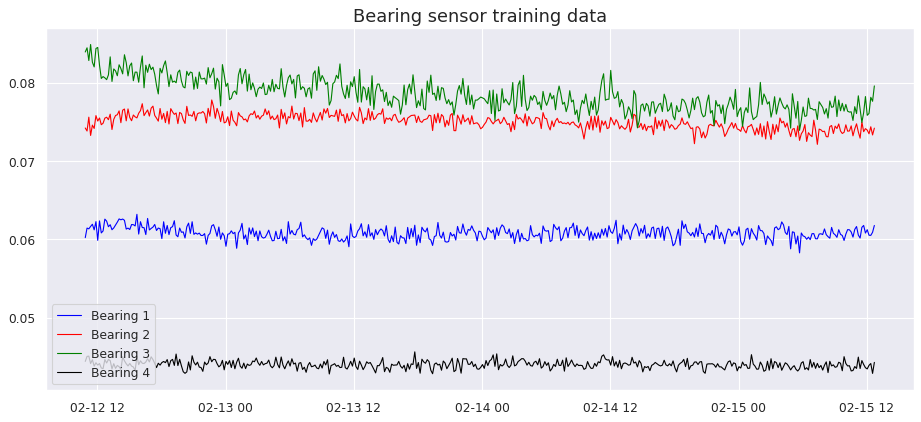

In [28]:
fig, ax = plt.subplots(figsize = (14,6), dpi=80)
ax.plot(train['Bearing 1'], label = 'Bearing 1', color = 'blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label = 'Bearing 2', color = 'red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label = 'Bearing 3', color = 'green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label = 'Bearing 4', color = 'black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor training data', fontsize=16)
plt.show()

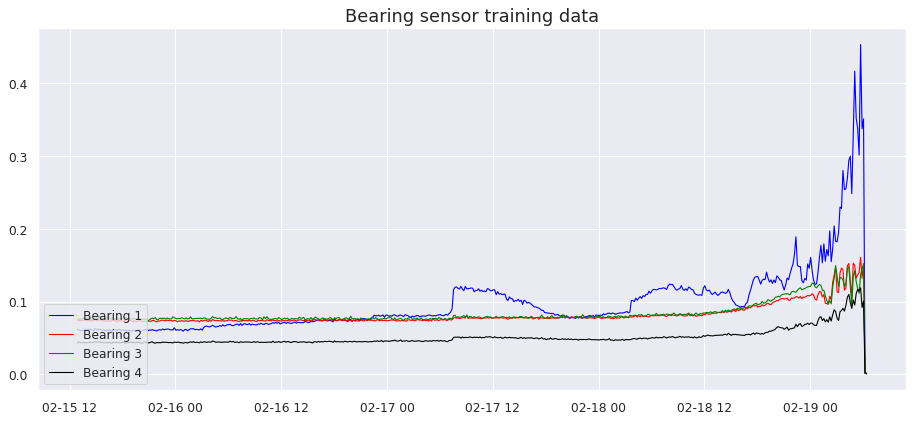

In [29]:
fig, ax = plt.subplots(figsize = (14,6), dpi=80)
ax.plot(test['Bearing 1'], label = 'Bearing 1', color = 'blue', animated = True, linewidth=1)
ax.plot(test['Bearing 2'], label = 'Bearing 2', color = 'red', animated = True, linewidth=1)
ax.plot(test['Bearing 3'], label = 'Bearing 3', color = 'green', animated = True, linewidth=1)
ax.plot(test['Bearing 4'], label = 'Bearing 4', color = 'black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor training data', fontsize=16)
plt.show()

Midway through the test set timeframe, the sensor patterns begin to change. Near the failure point, the bearing vibration readings become much stronger and oscillate wildly. To gain a slightly different perspective of the data, we will transform the signal from the time domain to the frequency domain using a Fourier transform.

In [33]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)
train_fft

array([[ 0.26283222+0.j        , -0.02368963-0.02978353j,
         0.0254928 +0.j        , -0.02368963+0.02978353j],
       [ 0.26483837+0.j        , -0.023002  -0.02876268j,
         0.0269874 +0.j        , -0.023002  +0.02876268j],
       [ 0.2649247 +0.j        , -0.02147605-0.0304904j ,
         0.02347043+0.j        , -0.02147605+0.0304904j ],
       ...,
       [ 0.25722491+0.j        , -0.01761702-0.03020841j,
         0.02011041+0.j        , -0.01761702+0.03020841j],
       [ 0.25481166+0.j        , -0.01671732-0.03042453j,
         0.02230343+0.j        , -0.01671732+0.03042453j],
       [ 0.25990678+0.j        , -0.01780658-0.02988671j,
         0.02286161+0.j        , -0.01780658+0.02988671j]])

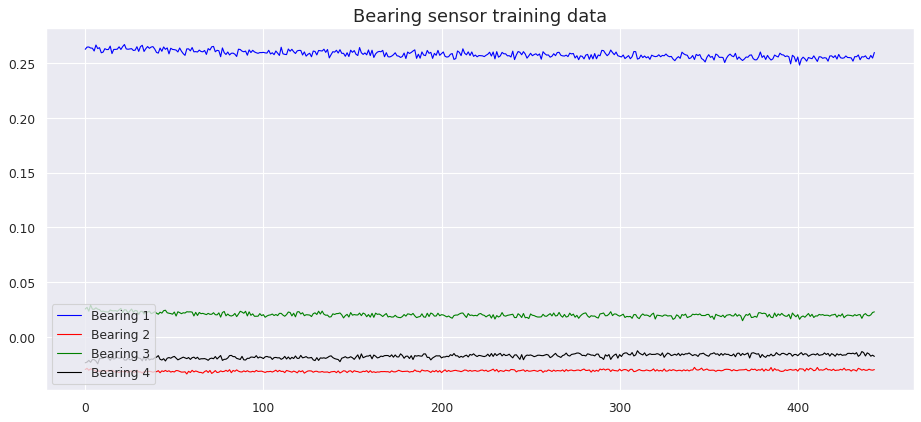

In [32]:
fig, ax = plt.subplots(figsize = (14,6), dpi=80)
ax.plot(train_fft[:,0].real, label = 'Bearing 1', color = 'blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label = 'Bearing 2', color = 'red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label = 'Bearing 3', color = 'green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label = 'Bearing 4', color = 'black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor training data', fontsize=16)
plt.show()

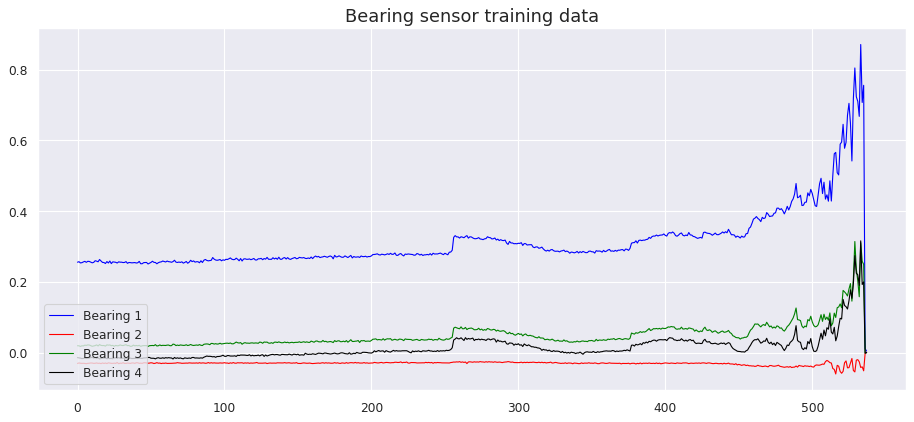

In [34]:
fig, ax = plt.subplots(figsize = (14,6), dpi=80)
ax.plot(test_fft[:,0].real, label = 'Bearing 1', color = 'blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label = 'Bearing 2', color = 'red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label = 'Bearing 3', color = 'green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label = 'Bearing 4', color = 'black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor training data', fontsize=16)
plt.show()

In [40]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = 'scaler_data'
joblib.dump(scaler, scaler_filename)
print(X_train.shape)
print(X_test.shape)

(444, 4)
(538, 4)


In [43]:
X_train = X_train.reshape(X_train.shape[0], 1, 4)
print('Training data shape:', X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, 4)
print('Training data shape:', X_test.shape)

Training data shape: (444, 1, 4)
Training data shape: (538, 1, 4)


## Neural Network Model
We will use an autoencoder neural network architecture for our anomaly detection model. The autoencoder architecture essentially learns an “identity” function. It will take the input data, create a compressed representation of the core / primary driving features of that data and then learn to reconstruct it again. For instance, input an image of a dog, it will compress that data down to the core constituents that make up the dog picture and then learn to recreate the original picture from the compressed version of the data.

The rationale for using this architecture for anomaly detection is that we train the model on the “normal” data and determine the resulting reconstruction error. Then, when the model encounters data that is outside the norm and attempts to reconstruct it, we will see an increase in the reconstruction error as the model was never trained to accurately recreate items from outside the norm.

In [0]:
def autoencoder_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(16, activation='relu', return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model

In the LSTM autoencoder network architecture, the first couple of neural network layers create the compressed representation of the input data, the encoder. We then use a repeat vector layer to distribute the compressed representational vector across the time steps of the decoder. The final output layer of the decoder provides us the reconstructed input data.

In [0]:
model = autoencoder_model(X_train)

In [48]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              68    

In [49]:
history = model.fit(X_train, X_train, epochs=100, batch_size=10, validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 1s 16ms/step - loss: 0.4498 - val_loss: 0.3323
Epoch 2/100
43/43 [==============================] - 0s 4ms/step - loss: 0.3876 - val_loss: 0.2704
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.3085 - val_loss: 0.1821
Epoch 4/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1664 - val_loss: 0.1408
Epoch 5/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1104 - val_loss: 0.1150
Epoch 6/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1034 - val_loss: 0.1092
Epoch 7/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1012 - val_loss: 0.1088
Epoch 8/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1007 - val_loss: 0.1083
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1007 - val_loss: 0.1085
Epoch 10/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0998 - val_loss: 0.1075
Epoch 11

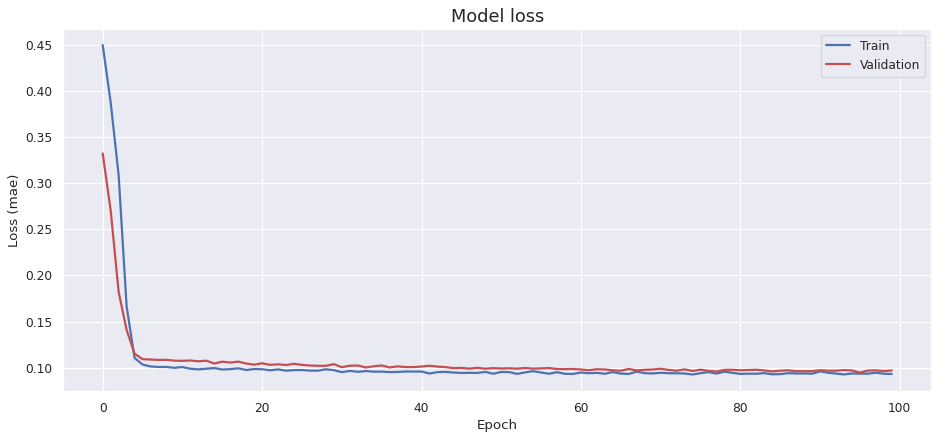

In [51]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

## Loss Distribution
By plotting the distribution of the calculated loss in the training set, we can determine a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” so that false positives are not triggered.

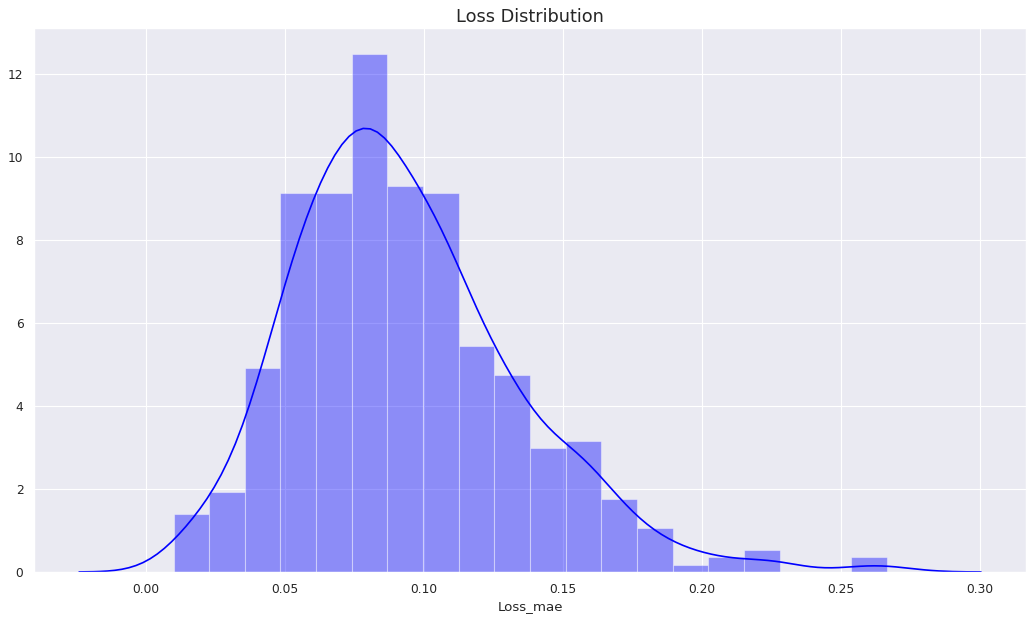

In [58]:
#plot the loss distribution of the training set
x_pred = model.predict(X_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=train.columns)
x_pred.index = train.index

scored = pd.DataFrame(index=train.index)
xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred-xtrain), axis=1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue');

In [75]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = np.reshape(X_pred, (X_pred.shape[0], 4), order='C')
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-xtest), axis=1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae']>scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.090754,0.275,False
2004-02-15 13:02:39,0.172563,0.275,False
2004-02-15 13:12:39,0.061652,0.275,False
2004-02-15 13:22:39,0.057412,0.275,False
2004-02-15 13:32:39,0.039220,0.275,False


In [0]:
# calculate the same metrics for the training set
# and merge all data in a single dataframe
scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(x_pred-xtrain), axis=1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae']>scored_train['Threshold']
scored = pd.concat([scored_train, scored])

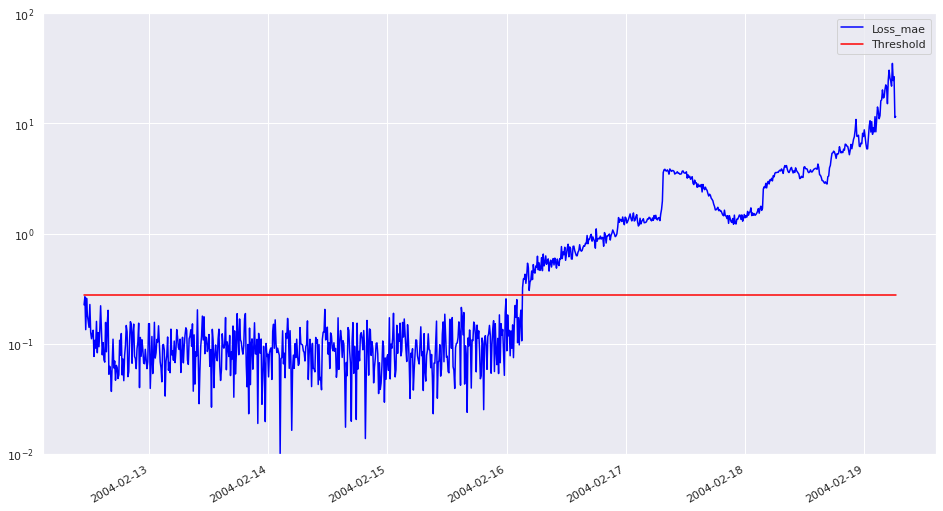

In [79]:
# plot bearing failure time plot
scored.plot(logy=True, figsize=(16,9), ylim=[1e-2, 1e2], color=['blue', 'red'])